In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Casia-FASD/going_modular')

In [ ]:
import helper_functions
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
from transformers import DeiTFeatureExtractor, DeiTModel
from PIL import Image
import torch.nn.functional as F

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
import timm

In [ ]:
class PatchImportance(nn.Module):
    def __init__(self, in_features):
        super(PatchImportance, self).__init__()
        self.fc = nn.Linear(in_features, 1)  # Single score per patch

    def forward(self, x):
        # Assuming x is of shape [batch, patches, features]
        importance_scores = self.fc(x).squeeze(-1)  # Shape [batch, patches]
        return importance_scores

In [ ]:
class CRA(nn.Module):
    def __init__(self, num_layers, in_features, heads=8, top_k=10):
        super(CRA, self).__init__()
        self.heads = heads
        self.scale = (in_features // heads) ** -0.5
        self.top_k = top_k

        self.query = nn.ModuleList([nn.Linear(in_features, in_features, bias=False) for _ in range(num_layers)])
        self.key = nn.ModuleList([nn.Linear(in_features, in_features, bias=False) for _ in range(num_layers)])
        self.value = nn.ModuleList([nn.Linear(in_features, in_features, bias=False) for _ in range(num_layers)])
        self.fusion = nn.Linear(in_features, in_features)
        self.importance = PatchImportance(in_features)

    def forward(self, features, adj):
        # Calculate importance scores and select top patches
        importance_scores = self.importance(features.squeeze(1))  # Squeeze out the singleton layer dimension for scoring
        _, top_indices = torch.topk(importance_scores, self.top_k, dim=1)  # Select top-k indices
        top_indices = top_indices.unsqueeze(-1).expand(-1, -1, features.size(-1))  # Prepare indices for gathering

        # Gather the selected patches
        selected_features = torch.gather(features.squeeze(1), 1, top_indices)  # Remove the layer dimension for gathering

        # Rest of the CRA processing
        B, P, C = selected_features.shape
        queries, keys, values = (self.query[0](selected_features), self.key[0](selected_features), self.value[0](selected_features))

        attention_scores = torch.einsum('bpc,bqc->bpq', queries, keys) * self.scale
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = attention_weights * adj[:, :P, :P]  # Adjust adj for selected patches

        weighted_values = torch.einsum('bpq,bqc->bpc', attention_weights, values)
        combined_features = torch.mean(weighted_values, dim=1)
        output = self.fusion(combined_features)
        return output

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MSWF(nn.Module):
    def __init__(self, num_layers, in_features, top_k=10):
        super(MSWF, self).__init__()
        self.num_layers = num_layers
        self.top_k = top_k

        # Initialize HL and LL feature extraction layers
        self.hl_feature_extractors = nn.ModuleList([nn.Linear(in_features, in_features) for _ in range(num_layers)])
        self.ll_feature_extractors = nn.ModuleList([nn.Linear(in_features, in_features) for _ in range(num_layers)])

        # Initialize score allocation layers
        self.hl_score_allocators = nn.ModuleList([nn.Linear(in_features, 1) for _ in range(num_layers)])
        self.ll_score_allocators = nn.ModuleList([nn.Linear(in_features, 1) for _ in range(num_layers)])

        # Initialize the PatchImportance layer
        self.importance = PatchImportance(in_features)

    def forward(self, features, adj):
        # Extract HL and LL features
        hl_features = [self.hl_feature_extractors[i](features.squeeze(1)) for i in range(self.num_layers)]
        ll_features = [self.ll_feature_extractors[i](features.squeeze(1)) for i in range(self.num_layers)]

        # Allocate scores to HL and LL features
        hl_scores = [torch.sigmoid(self.hl_score_allocators[i](hl_features[i])) for i in range(self.num_layers)]
        ll_scores = [torch.sigmoid(self.ll_score_allocators[i](ll_features[i])) for i in range(self.num_layers)]

        # Calculate importance scores and select top features
        importance_scores = self.importance(features.squeeze(1))
        _, top_indices = torch.topk(importance_scores, self.top_k, dim=1)
        top_indices = top_indices.unsqueeze(-1).expand(-1, -1, features.size(-1))

        # Gather the selected features
        selected_hl_features = [torch.gather(hl_features[i], 1, top_indices) for i in range(self.num_layers)]
        selected_ll_features = [torch.gather(ll_features[i], 1, top_indices) for i in range(self.num_layers)]

        # Complementary hierarchical fusion
        fused_features = [selected_hl_features[i] + selected_ll_features[i] for i in range(self.num_layers)]

        return fused_features




# # Example usage
# batch_size = 4
# in_features = 768
# num_layers = 12
# top_k = 10

# model = MSWF(num_layers=num_layers, in_features=in_features, top_k=top_k)

# # Random input tensor
# images = torch.randn(batch_size, in_features)

# # Forward pass
# fused_features = model(images)
# print("Output shape:", fused_features[0].shape)  # Shape of the first fused feature


In [ ]:
class FeatureExtraction(nn.Module):
    def __init__(self, num_layers=12, num_classes=2, in_features=768):
        super(FeatureExtraction, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.cra = CRA(num_layers=num_layers, in_features=in_features)

    def forward(self, x):
        x = self.vit.forward_features(x)
        x = x.unsqueeze(1)  # Prepare for CRA processing
        adj = torch.eye(x.shape[2], device=x.device).expand(x.shape[0], -1, -1)  # Dummy adjacency matrix
        x = self.cra(x, adj)
        return x

In [ ]:
# Testing the updated model
model = FeatureExtraction()
batch_size = 4
image_size = 224
images = torch.randn(batch_size, 3, image_size, image_size)

fused_features = model(images)
print("Output shape from CRA:", fused_features.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Output shape from CRA: torch.Size([4, 768])


In [ ]:
class FaceSpoofDetector(nn.Module):
    def __init__(self, num_layers=12, in_features=768, num_classes=2):
        super(FaceSpoofDetector, self).__init__()
        self.feature_extractor = FeatureExtraction(num_layers=num_layers, in_features=in_features)
        self.mswf = MSWF(num_layers=num_layers, in_features=in_features)
        self.classifier = nn.Linear(in_features, num_classes)  # Classifier layer for real or spoof

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract and enhance features
        x = self.mswf(x)  # Apply MSWF for complementary hierarchical fusion
        x = self.classifier(x)  # Classify as real or spoof
        return x

In [ ]:
# Example of using the FaceSpoofDetector
model = FaceSpoofDetector()
images = torch.randn(4, 3, 224, 224)  # Sample input batch
output = model(images)
print("Classifier Output:", output.shape)

Classifier Output: torch.Size([4, 2])


In [ ]:
pip install torchsummary

In [ ]:
from torchsummary import summary

# Assuming your FaceSpoofDetector has already been defined and instantiated
model = FaceSpoofDetector(num_layers=12, in_features=768, num_classes=2)
model.to(device)

# Print the model summary
# Replace (3, 224, 224) with the correct input dimensions if different
summary(model, input_size=(3, 224, 224))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/siw/justsiw.pth'))

<All keys matched successfully>

In [ ]:
class_names = ['real', 'spoof']

In [ ]:
import os

def count_files(directory):
    """Count the number of files in the given directory, excluding subdirectories."""
    return sum(1 for item in os.listdir(directory) if os.path.isfile(os.path.join(directory, item)))

# Specify the directory you want to check
directory_path = '/content/drive/MyDrive/siw/train/real'

# Get the number of files in the directory
file_count = count_files(directory_path)
print(f"There are {file_count} files in the directory '{directory_path}'.")

There are 5386 files in the directory '/content/drive/MyDrive/siw/train/real'.


In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Path to the root directory of your dataset
data_dir = '/content/drive/MyDrive/siw/'

# Load training dataset
train_dataset = ImageFolder(root=data_dir + 'train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Path to the root directory of your dataset
data_dir = '/content/drive/MyDrive/siw/'

# Load development dataset
dev_dataset = ImageFolder(root=data_dir + 'val (1)', transform=transform)
dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False)

# Load evaluation dataset
eval_dataset = ImageFolder(root=data_dir + 'test (1)', transform=transform)
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False)

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Casia-FASD')

In [ ]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the modified ViT model
set_seeds()
modified_vit_results = engine.train(model=model,
                                     train_dataloader=train_loader,
                                     test_dataloader=dev_loader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=10,
                                     device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2019 | train_acc: 0.9263 | test_loss: 0.6451 | test_acc: 0.8508
Epoch: 2 | train_loss: 0.0782 | train_acc: 0.9700 | test_loss: 0.2048 | test_acc: 0.9651
Epoch: 3 | train_loss: 0.0530 | train_acc: 0.9849 | test_loss: 0.5809 | test_acc: 0.8101
Epoch: 4 | train_loss: 0.0229 | train_acc: 0.9931 | test_loss: 0.2839 | test_acc: 0.9348
Epoch: 5 | train_loss: 0.0351 | train_acc: 0.9888 | test_loss: 0.2389 | test_acc: 0.9519
Epoch: 6 | train_loss: 0.0252 | train_acc: 0.9906 | test_loss: 0.0557 | test_acc: 0.9832
Epoch: 7 | train_loss: 0.0038 | train_acc: 0.9992 | test_loss: 0.3481 | test_acc: 0.9530
Epoch: 8 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3401 | test_acc: 0.9542
Epoch: 9 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3408 | test_acc: 0.9542
Epoch: 10 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3438 | test_acc: 0.9566


In [ ]:
# Save the model to a file
torch.save(model.state_dict(), '/content/drive/MyDrive/siw/justsiw.pth')

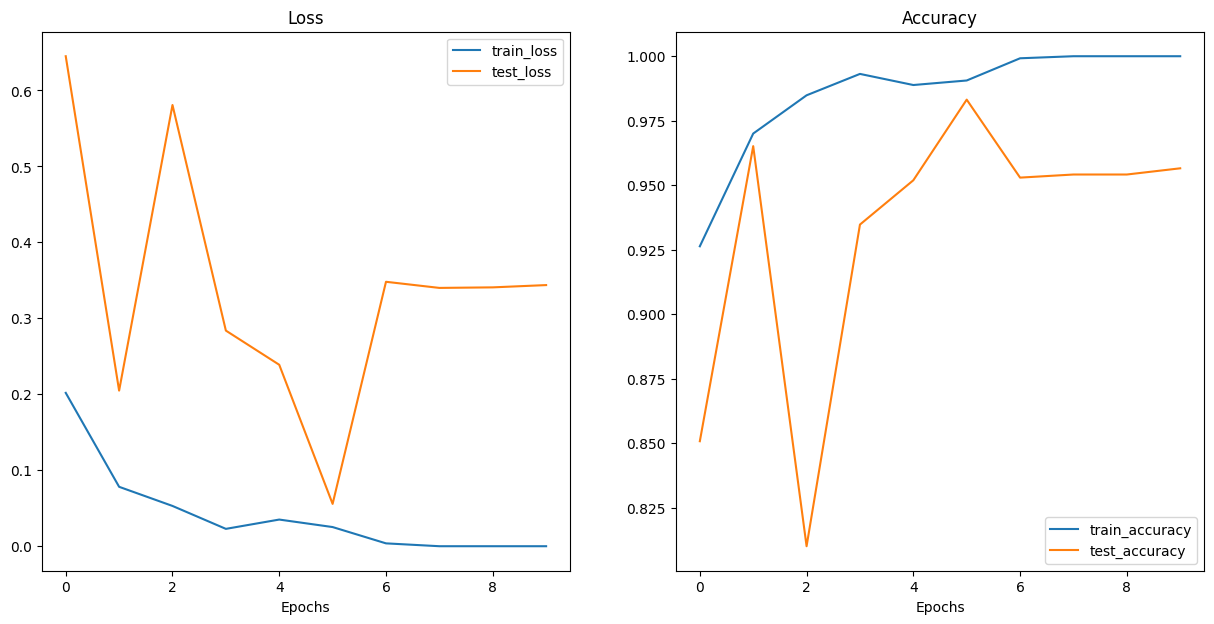

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(modified_vit_results)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


THIS IS TESTING DATASET METRICS AND CM

In [ ]:
def get_all_predictions_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Assume `test_loader` is set up properly
predictions, labels = get_all_predictions_and_labels(model, eval_loader, device)

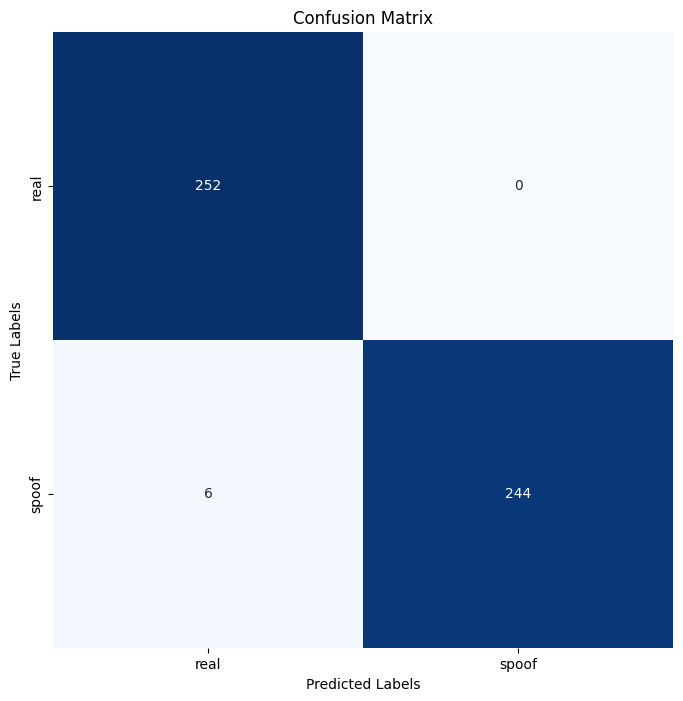

In [ ]:
def plot_confusion_matrix(labels, predictions, classes):
    cm = confusion_matrix(labels, predictions)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    plt.show()
    return cm

# Define your class names based on the indices
class_names = ['real', 'spoof']
cm = plot_confusion_matrix(labels, predictions, class_names)

In [ ]:
def calculate_apcer_bpcer(confusion_mat):
    # Assuming '1' is the positive class (spoof) and '0' is the negative class (bona fide)
    tn, fp, fn, tp = confusion_mat.ravel()
    apcer = fn / (fn + tp)  # Missed spoofs
    bpcer = fp / (fp + tn)  # Falsely identified spoofs
    return apcer, bpcer

apcer, bpcer = calculate_apcer_bpcer(cm)
print(f"APCER: {apcer:.4f}")
print(f"BPCER: {bpcer:.4f}")

APCER: 0.0240
BPCER: 0.0000


In [ ]:
from sklearn.metrics import confusion_matrix

# Function to calculate metrics
def calculate_metrics(model, data_loader, device, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.view(-1).tolist())
            all_labels.extend(target.view(-1).tolist())

    test_loss /= len(data_loader.dataset)
    accuracy = correct / len(data_loader.dataset)

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    TN, FP, FN, TP = cm.ravel()

    # Calculate APCER, BPCER, and ACER
    apcer = FP / (FP + TN)
    bpcer = FN / (FN + TP)
    acer = (apcer + bpcer) / 2

    return test_loss, accuracy, apcer, bpcer, acer

# Calculate metrics
test_loss, accuracy, apcer, bpcer, acer = calculate_metrics(model, eval_loader, device, loss_fn)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"BPCER: {bpcer:.4f}")
print(f"ACER: {acer:.4f}")


Test Loss: 0.0034
Test Accuracy: 0.9880
APCER: 0.0000
BPCER: 0.0240
ACER: 0.0120


TRAINING DATASET AND DEV DATASET APCER BPCER AND ACER

In [ ]:
from sklearn.metrics import confusion_matrix

# Function to calculate metrics
def calculate_metrics(model, data_loader, device, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.view(-1).tolist())
            all_labels.extend(target.view(-1).tolist())


    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    TN, FP, FN, TP = cm.ravel()

    # Calculate APCER, BPCER, and ACER
    apcer = FP / (FP + TN)
    bpcer = FN / (FN + TP)
    acer = (apcer + bpcer) / 2

    return apcer, bpcer, acer

# Calculate metrics
apcer, bpcer, acer = calculate_metrics(model, dev_loader, device, loss_fn)

print(f"APCER: {apcer:.4f}")
print(f"BPCER: {bpcer:.4f}")
print(f"ACER: {acer:.4f}")


APCER: 0.0000
BPCER: 0.0918
ACER: 0.0459


In [ ]:
from sklearn.metrics import confusion_matrix

# Function to calculate metrics
def calculate_metrics(model, data_loader, device, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.view(-1).tolist())
            all_labels.extend(target.view(-1).tolist())


    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    TN, FP, FN, TP = cm.ravel()

    # Calculate APCER, BPCER, and ACER
    apcer = FP / (FP + TN)
    bpcer = FN / (FN + TP)
    acer = (apcer + bpcer) / 2

    return apcer, bpcer, acer

# Calculate metrics
apcer, bpcer, acer = calculate_metrics(model, train_loader, device, loss_fn)

print(f"APCER: {apcer:.4f}")
print(f"BPCER: {bpcer:.4f}")
print(f"ACER: {acer:.4f}")


APCER: 0.0000
BPCER: 0.0000
ACER: 0.0000


Confusion matrix for training dataset

In [ ]:
def get_all_predictions_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Assume `test_loader` is set up properly
predictions, labels = get_all_predictions_and_labels(model, train_loader, device)

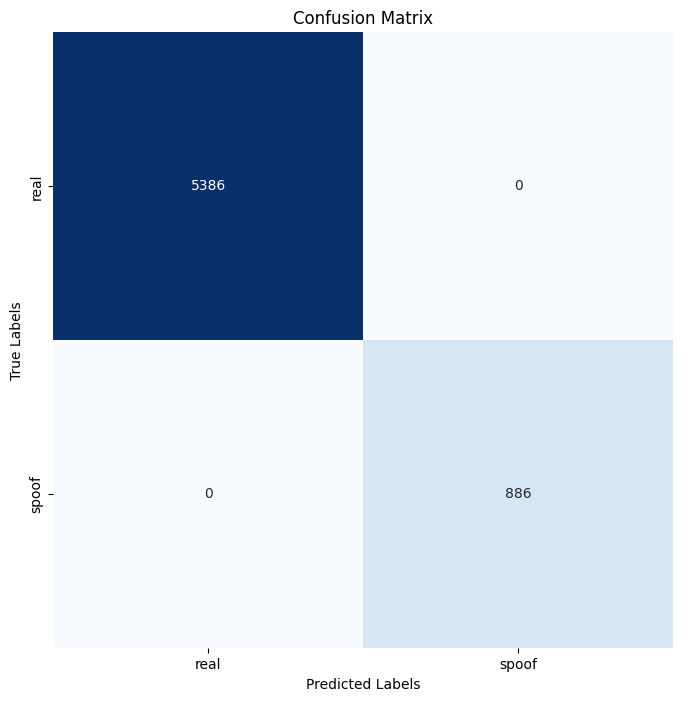

In [ ]:
def plot_confusion_matrix(labels, predictions, classes):
    cm = confusion_matrix(labels, predictions)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    plt.show()
    return cm

# Define your class names based on the indices
class_names = ['real', 'spoof']
cm = plot_confusion_matrix(labels, predictions, class_names)

Testing.

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Casia-FASD/going_modular')

tensor([[9.9999e-01, 1.1751e-05]], device='cuda:0')
something: tensor([0], device='cuda:0')


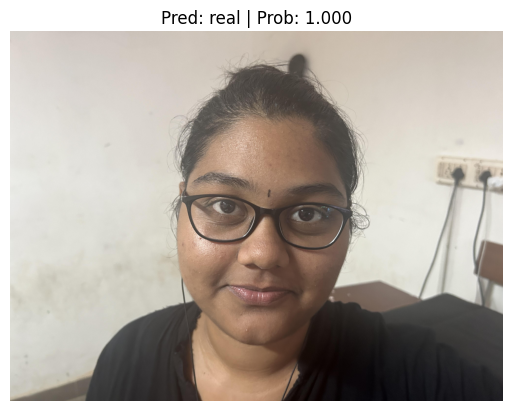

In [ ]:
 import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/fyp-2nd/custom-dataset/real/real2.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

tensor([[0.0013, 0.9987]], device='cuda:0')
something: tensor([1], device='cuda:0')


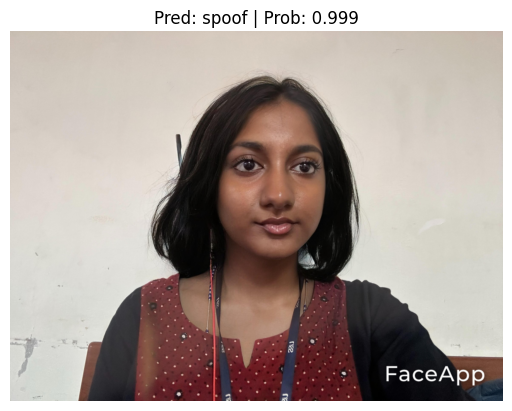

In [ ]:
import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/unnamed (2).jpg"
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

tensor([[0.0864, 0.9136]], device='cuda:0')
something: tensor([1], device='cuda:0')


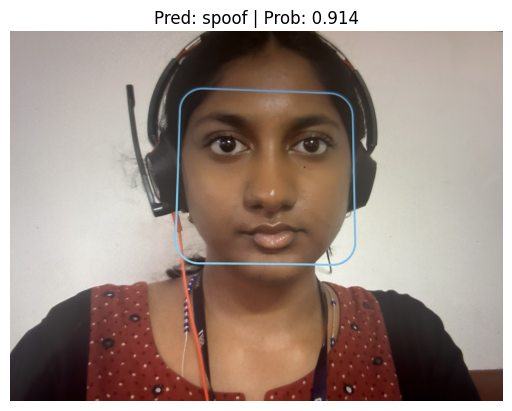

In [ ]:
import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/fyp-2nd/custom-dataset/spoof/spoof1.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

tensor([[3.1988e-05, 9.9997e-01]], device='cuda:0')
something: tensor([1], device='cuda:0')


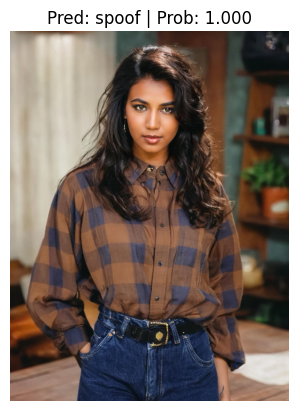

In [ ]:
import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/fyp-2nd/custom-dataset/spoof/testing.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

tensor([[9.9999e-01, 1.1751e-05]], device='cuda:0')
something: tensor([0], device='cuda:0')


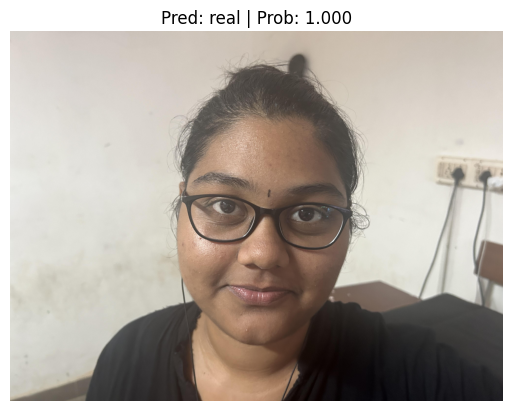

In [ ]:
import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/fyp-2nd/custom-dataset/real/real2.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

tensor([[9.9989e-01, 1.1038e-04]], device='cuda:0')
something: tensor([0], device='cuda:0')


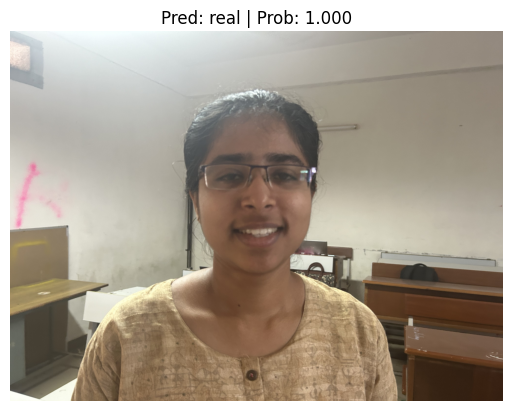

In [ ]:
import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/fyp-2nd/custom-dataset/real/real4.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)